In [1]:
import pandas as pd
import numpy as np
import nibabel as nib
from tqdm import tqdm
import logging
from sklearn.model_selection import StratifiedKFold
import time
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
import sys
import os

In [2]:
import matplotlib.pyplot as plt 
from scipy.ndimage.interpolation import zoom

In [3]:
from fastai2.basics import *

In [4]:
torch.cuda.set_device(6)

In [5]:
# data_path = Path('/home/akanksha/brainlabs/projects/brain-transfer')
data_path = Path('/home/akanksha/brainlabs/projects/brain-seg/data_folder/preprocessing/ADNIBrain')
files = get_files(data_path, extensions=['.gz'])
files = L([f for f in files if f.parent.name in ['AD','CN']])

In [6]:
classes = Counter([f.parent.name for f in files]); classes
399/(399+424)

0.4848116646415553

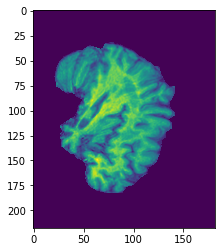

In [7]:
img = nib.load(files[0]).get_fdata()
plt.imshow(img[50])

In [8]:
img.shape

(182, 218, 182)

In [9]:
def norm(data):
    return (data - data.min()) / (data.max() - data.min())

In [10]:
def resize(data, target_shape=[96, 128, 96]):
    factor = [float(t) / float(s) for t, s in zip(target_shape, data.shape)]
    resized = zoom(data, zoom=factor, order=1, prefilter=False)
    #print(resized)
    return resized

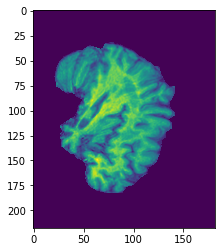

In [11]:
n = norm(img)
plt.imshow(n[50, :])

In [12]:
def resize(data, target_shape=[96, 112, 96]):
    factor = [float(t) / float(s) for t, s in zip(target_shape, data.shape)]
    resized = zoom(data, zoom=factor, order=1, prefilter=False)
    #print(resized)
    return resized

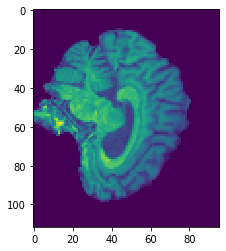

In [13]:
n = norm(resize(img))
plt.imshow(n[50, :])

In [14]:
def get_nii(path):
    img = nib.load(str(path)).get_fdata()
    img_n = norm(resize(img))
    return torch.from_numpy(img_n).view(1, *img_n.shape).float()

In [15]:
def get_lbl(path):
    return int(path.parent.name == 'AD')

In [16]:
tfms = [[get_nii],[get_lbl]]
dsets = Datasets(files, tfms, splits=RandomSplitter()(files))

In [17]:
def get_data_gen(files, bs, sz=None, nw=8, 
                 batch_xtra=None, after_item=None, with_aug=True, test=False, **kwargs):
    tfms = [[get_nii],[get_lbl]]
    dsets = Datasets(files, tfms, splits=RandomSplitter(seed=42)(files))
    dls = dsets.dataloaders(bs=bs, num_workers=nw)
    dls.c = 1
    return dls

In [18]:
dls = get_data_gen(files,bs=4)

In [19]:
xb,yb = dls.one_batch()

In [20]:
from rsna_retro.imports import *
from rsna_retro.metadata import *
from rsna_retro.preprocess import *
from rsna_retro.train import *
from rsna_retro.train3d import *
from rsna_retro.trainfull3d_labels import *

Loading imports


In [21]:
# m = get_3d_head()
# config=dict(custom_head=m)
# learn = get_learner(dls, xresnet18, get_loss(), config=config)
# hook = ReshapeBodyHook(learn.model[0])

# # learn.add_cb(RowLoss())

In [22]:
#export
class Flat3d(Module):
    def forward(self, x): return x.view(x.shape[0],-1)

In [23]:

#export
class XResNet3D(nn.Sequential):
    @delegates(ResBlock)
    def __init__(self, block, expansion, layers, p=0.0, c_in=3, c_out=1000, stem_szs=(32,32,64),
                 widen=1.0, sa=False, act_cls=defaults.activation, **kwargs):
        store_attr(self, 'block,expansion,act_cls')
        stem_szs = [c_in, *stem_szs]
        stem = [ConvLayer(stem_szs[i], stem_szs[i+1], stride=2 if i==0 else 1, act_cls=act_cls, ndim=3)
                for i in range(3)]

        block_szs = [int(o*widen) for o in [64,128,256,512] +[256]*(len(layers)-4)]
        block_szs = [64//expansion] + block_szs
        blocks = [self._make_layer(ni=block_szs[i], nf=block_szs[i+1], blocks=l,
                                   stride=1 if i==0 else 2, sa=sa and i==len(layers)-4, **kwargs)
                  for i,l in enumerate(layers)]
        super().__init__(
            *stem, nn.MaxPool3d(kernel_size=3, stride=2, padding=1),
            *blocks,
            *get_3d_head(c_out=c_out)
        )
        init_cnn(self)

    def _make_layer(self, ni, nf, blocks, stride, sa, **kwargs):
        return nn.Sequential(
            *[self.block(self.expansion, ni if i==0 else nf, nf, stride=stride if i==0 else 1,
                      sa=sa and i==(blocks-1), act_cls=self.act_cls, **kwargs)
              for i in range(blocks)])

In [24]:
def get_3d_head(p=0.0, c_out=3, in_feat=512):
    m = nn.Sequential(#Batchify(),
        ConvLayer(in_feat,512,stride=2,ndim=3), # 8
#         ConvLayer(512,1024,stride=2,ndim=3), # 4
#         ConvLayer(1024,1024,stride=2,ndim=3), # 2
        nn.AdaptiveAvgPool3d((1, 1, 1)), #Batchify(), 
        Flat3d(), nn.Dropout(p),
        nn.Linear(512, c_out))
    init_cnn(m)
    return m

In [25]:
#export
def xres3d(c_out=6, **kwargs):
    m = XResNet3D(ResBlock, expansion=1, layers=[2, 2,  2, 2], c_out=c_out, ndim=3, **kwargs)
    init_cnn(m)
    return m

In [31]:
m = xres3d(c_in=1, c_out=1).cuda()
learn = get_learner(dls, m, lf=BCEWithLogitsLossFlat(), metrics=accuracy_multi)

In [32]:
with torch.no_grad():
    out = m(xb)

learn.loss_func(out, yb)

tensor(0.5660, device='cuda:6')

(0.00010000000474974513, 5.248074330665986e-07)

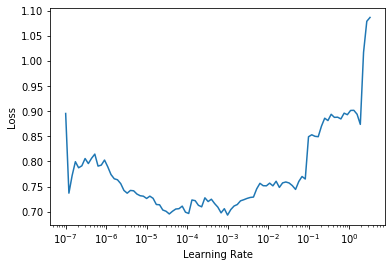

In [28]:
learn.lr_find()

In [29]:
# targs = [yb for xb,yb in dls.valid]
# 1 - torch.stack(targs).float().mean()
0.414634

0.414634

In [34]:
do_fit(learn, 10, 1e-4)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.668178,0.610026,0.682927,00:45
1,0.653964,0.718646,0.536585,00:44
2,0.621653,0.777802,0.542683,00:44
3,0.556467,0.577712,0.689024,00:43
4,0.479464,0.510062,0.731707,00:44
5,0.365153,0.507703,0.780488,00:43
6,0.228366,0.439205,0.817073,00:42
7,0.156877,0.454680,0.804878,00:43
8,0.157642,0.442259,0.817073,00:44
9,0.161542,0.438358,0.829268,00:44


## 2d -> 3d head

In [41]:
learn.summary()

XResNet3D (Input shape: ['2 x 1 x 96 x 112 x 96'])
Layer (type)         Output Shape         Param #    Trainable 
Conv3d               2 x 32 x 48 x 56 x   864        True      
________________________________________________________________
BatchNorm3d          2 x 32 x 48 x 56 x   64         True      
________________________________________________________________
ReLU                 2 x 32 x 48 x 56 x   0          False     
________________________________________________________________
Conv3d               2 x 32 x 48 x 56 x   27,648     True      
________________________________________________________________
BatchNorm3d          2 x 32 x 48 x 56 x   64         True      
________________________________________________________________
ReLU                 2 x 32 x 48 x 56 x   0          False     
________________________________________________________________
Conv3d               2 x 64 x 48 x 56 x   55,296     True      
_______________________________________________

In [43]:
class ReshapeBodyHook():
    def __init__(self, body):
        super().__init__()
        self.pre_reg = body.register_forward_pre_hook(self.pre_hook)
        self.reg = body.register_forward_hook(self.forward_hook)
        self.shape = None

    def deregister(self):
        self.reg.remove()
        self.pre_reg.remove()

    def pre_hook(self, module, input):
        x = input[0]
        bs,nc,w,d,h = x.shape
        self.shape = x.shape
        self.bs = bs
        self.w = w
        return x.view(bs*96,1,112,96)
        return (x.view(-1, *x.shape[3:]),)

    def forward_hook(self, module, input, x):
#         print(x.view(2,512,-1,*x.shape[2:]).shape)
        return x.view(self.bs,512,self.w,*x.shape[2:])
        return x.view(*self.shape[:3], *x.shape[1:])

In [46]:
m = get_3d_head(c_out=1)
config=dict(custom_head=m)
arch = partial(xresnet18, c_in=1, c_out=1)
# learn = get_learner(dls, arch, get_loss(), config=config)
learn = get_learner(dls, arch, lf=BCEWithLogitsLossFlat(), metrics=accuracy_multi, config=config)
hook = ReshapeBodyHook(learn.model[0])

# learn.add_cb(RowLoss())

In [47]:
do_fit(learn, 10, 1e-4)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.676566,0.646491,0.634146,00:44
1,0.642137,0.611541,0.664634,00:43
2,0.625383,1.477001,0.414634,00:42
3,0.584167,0.655899,0.652439,00:41
4,0.542100,0.544813,0.731707,00:43
5,0.515905,1.090881,0.536585,00:44
6,0.421874,0.474865,0.774390,00:43
7,0.434503,0.992448,0.585366,00:42
8,0.376859,0.476503,0.731707,00:44
9,0.326345,0.840604,0.652439,00:44


KeyboardInterrupt: 